<a href="https://colab.research.google.com/github/CristianRamosMedina/Deep-Learning-NER/blob/main/DeepLearningNER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NAMED ENTITY RECOGNITION

In [ ]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Carga y procesamiento de datos

In [ ]:
# Cargar y procesar los datos
def load_data(file):
    with open(file, 'r') as f:
        data = json.load(f)
    samples = data["samples"]
    texts = [sample["tokens"] for sample in samples]
    tags = [sample["tags"] for sample in samples]
    return texts, tags

# Carga de datos
train_texts, train_tags = load_data('/content/drive/MyDrive/ner_promed_train.json')
test_texts, test_tags = load_data('/content/drive/MyDrive/ner_promed_test.json')

# Etiquetas y tokens

In [ ]:
# Creación de un conjunto de etiquetas
labels = set()
for tags in train_tags + test_tags:
    labels.update(tags)
labels = list(labels)

# Codificador de etiquetas
label_encoder = LabelEncoder()
label_encoder.fit(labels)

# Crear un contador para todos los tokens en los datos de entrenamiento
token_counter = Counter(token for text in train_texts for token in text)

# Agregar tokens especiales para el manejo de palabras desconocidas y padding
vocab = {"<PAD>": 0, "<UNK>": 1}
vocab.update({token: idx + 2 for idx, (token, _) in enumerate(token_counter.most_common())})

# Tamaño del vocabulario
vocab_size = len(vocab)

# Creación de los dataset

In [ ]:
class NERDataset(Dataset):
    def __init__(self, texts, tags, label_encoder, max_length=128, vocab=None):
        self.texts = texts
        self.tags = tags
        self.label_encoder = label_encoder
        self.max_length = max_length
        self.vocab = vocab

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = self.texts[idx]
        tags = self.tags[idx]
        token_indices = [self.vocab.get(token, self.vocab["<UNK>"]) for token in tokens]
        token_indices = token_indices[:self.max_length] + [self.vocab["<PAD>"]] * (self.max_length - len(token_indices))
        tag_indices = self.label_encoder.transform(tags)
        tag_indices = tag_indices[:self.max_length].tolist() + [-100] * (self.max_length - len(tag_indices))
        return torch.tensor(token_indices, dtype=torch.long), torch.tensor(tag_indices, dtype=torch.long)

# Creación de Datasets
train_dataset = NERDataset(train_texts, train_tags, label_encoder, vocab=vocab)
test_dataset = NERDataset(test_texts, test_tags, label_encoder, vocab=vocab)

# Función para manejar los lotes en el DataLoader
def collate_fn(batch):
    tokens, labels = zip(*batch)
    return torch.stack(tokens), torch.stack(labels)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)


# Modelo RNN

In [ ]:
# Definir el modelo RNN
class RNNModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, output_size, bidirectional, dropout):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.fc(self.dropout(x))
        return x

# Inicializar el modelo RNN con el tamaño correcto del vocabulario
output_size = len(label_encoder.classes_)
rnn_model = RNNModel(vocab_size, hidden_size=128, num_layers=2, output_size=output_size, bidirectional=True, dropout=0.8)

# Definir el optimizador y la función de pérdida
optimizer = optim.Adam(rnn_model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss(ignore_index=-100)


# Función de entrenamiento
def train(model, iterator, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for tokens, labels in iterator:
        tokens, labels = tokens.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(tokens)
        predictions = predictions.view(-1, output_size)
        labels = labels.view(-1)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(iterator)

# Función de evaluación
def evaluate(model, iterator, criterion, device):
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_labels = []

    for tokens, labels in iterator:
        tokens, labels = tokens.to(device), labels.to(device)
        with torch.no_grad():
            predictions = model(tokens)
        predictions = predictions.view(-1, output_size)
        labels = labels.view(-1)
        loss = criterion(predictions, labels)
        total_loss += loss.item()
        all_predictions.extend(predictions.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    return total_loss / len(iterator), all_predictions, all_labels

# Métricas de rendimiento

In [ ]:
# Función para calcular métricas de rendimiento
def calculate_metrics(predictions, labels, label_encoder):
    # Convertir predicciones y etiquetas a etiquetas textuales
    predictions = label_encoder.inverse_transform(predictions)
    labels = label_encoder.inverse_transform(labels)

    # Calcular y devolver las métricas
    report = classification_report(labels, predictions, output_dict=True, zero_division=0)
    f1_macro = report['macro avg']['f1-score']
    return f1_macro

# Configurar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Mover el modelo al dispositivo seleccionado
rnn_model = rnn_model.to(device)


Using cuda device


# Visualización del entrenamiento

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Epoch: 5001, Train Loss: 0.004
Epoch: 5002, Train Loss: 0.004
Epoch: 5003, Train Loss: 0.004
Epoch: 5004, Train Loss: 0.004
Epoch: 5005, Train Loss: 0.004
Epoch: 5006, Train Loss: 0.004
Epoch: 5007, Train Loss: 0.004
Epoch: 5008, Train Loss: 0.004
Epoch: 5009, Train Loss: 0.004
Epoch: 5010, Train Loss: 0.004, F1 Macro: 0.324
Epoch: 5011, Train Loss: 0.004
Epoch: 5012, Train Loss: 0.004
Epoch: 5013, Train Loss: 0.004
Epoch: 5014, Train Loss: 0.004
Epoch: 5015, Train Loss: 0.004
Epoch: 5016, Train Loss: 0.004
Epoch: 5017, Train Loss: 0.004
Epoch: 5018, Train Loss: 0.004
Epoch: 5019, Train Loss: 0.004
Epoch: 5020, Train Loss: 0.004, F1 Macro: 0.326
Epoch: 5021, Train Loss: 0.004
Epoch: 5022, Train Loss: 0.004
Epoch: 5023, Train Loss: 0.004
Epoch: 5024, Train Loss: 0.004
Epoch: 5025, Train Loss: 0.004
Epoch: 5026, Train Loss: 0.004
Epoch: 5027, Train Loss: 0.004
Epoch: 5028, Train Loss: 0.004
Epoch: 5029, Train Loss: 0.004


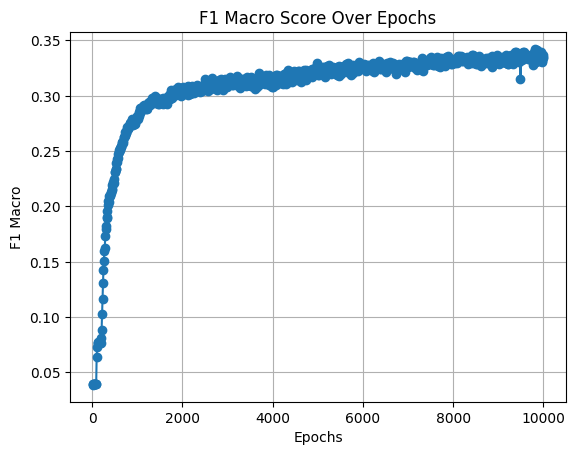

In [ ]:
# Entrenamiento y Evaluación con seguimiento de F1 macro promedio
f1_scores = []
N_EPOCHS = 10000
for epoch in range(N_EPOCHS):
    train_loss = train(rnn_model, train_loader, optimizer, criterion, device)

    if (epoch + 1) % 10 == 0:
        test_loss, test_predictions, test_labels = evaluate(rnn_model, test_loader, criterion, device)
        f1_macro = calculate_metrics(test_predictions, test_labels, label_encoder)
        f1_scores.append(f1_macro)
        print(f"Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, F1 Macro: {f1_macro:.3f}")
    else:
        print(f"Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}")

# Visualizar la puntuación F1 macro promedio
plt.plot(range(10, N_EPOCHS + 1, 10), f1_scores, marker='o')
plt.xlabel('Epochs')
plt.ylabel('F1 Macro')
plt.title('F1 Macro Score Over Epochs')
plt.grid(True)
plt.show()

# Visualización de predicciones

In [ ]:
# Función para invertir el mapeo del vocabulario: de índice a token
def index_to_token(vocab, index):
    for token, idx in vocab.items():
        if idx == index:
            return token
    return "<UNK>"  # Retorna UNK si no se encuentra el índice

# Función de visualización de predicciones
def visualize_predictions(model, dataset, label_encoder, vocab, num_samples=5):
    model.eval()
    samples = torch.utils.data.Subset(dataset, indices=range(num_samples))
    loader = DataLoader(samples, batch_size=1)

    for tokens, true_labels in loader:
        tokens, true_labels = tokens.to(device), true_labels.to(device)
        with torch.no_grad():
            predictions = model(tokens)
            predictions = predictions.view(-1, output_size)
            predicted_labels = predictions.argmax(dim=1).cpu().numpy()

        # Convertir índices a etiquetas
        predicted_labels = label_encoder.inverse_transform(predicted_labels)
        true_labels = true_labels.view(-1).cpu().numpy()
        true_labels = label_encoder.inverse_transform(true_labels)

        # Visualizar las predicciones y las etiquetas reales
        token_list = [index_to_token(vocab, t) for t in tokens[0].cpu().numpy()]
        print("Tokens: ", token_list)
        print("True Labels: ", true_labels)
        print("Predicted Labels: ", predicted_labels)
        print("\n")

# Llamar a la función después de entrenar el modelo
visualize_predictions(rnn_model, test_dataset, label_encoder, vocab, num_samples=5)

Tokens:  ['Título', ':', 'HANTAVIRUS', '-', 'BRASIL', '(', 'MG', ')', '.', 'Fecha', ':', 'Dom', '6', 'de', 'julio', 'de', '2003', '.', 'La', 'Secretaria', 'de', 'Salud', 'de', 'Minas', 'Gerais', 'confirmó', 'que', 'una', 'persona', 'más', 'pudo', 'haber', 'sido', 'víctima', 'de', 'hantavirosis', 'en', 'S', 'ã', 'o', '<UNK>', ',', 'en', 'la', 'región', 'del', 'Alto', '<UNK>', '.', 'Según', 'la', 'secretaria', ',', 'un', 'equipo', 'de', 'técnicos', 'investiga', 'el', 'caso', ',', 'el', 'cual', '<UNK>', 'a', 'una', 'persona', 'que', 'tuvo', 'exposición', 'en', 'la', 'zona', 'rural', '.', 'En', 'este', 'año', ',', 'diez', 'ocurrencias', 'de', 'infecciones', '<UNK>', 'hantavirus', 'fueron', 'confirmadas', 'en', 'el', 'estado', ',', 'con', 'siete', 'muertes', '-', 'tres', 'en', '<UNK>', ',', 'dos', 'en', 'S', 'ã', 'o', '<UNK>', ',', 'una', 'en', '<UNK>', 'y', 'otra', 'en', '<UNK>', 'Santo', 'de', 'Minas', '.', 'Ayer', ',', 'la', '<UNK>', 'de', 'Acciones', '<UNK>', 'de', 'Salud', 'de', '<UNK>

# Cálculo de métricas en el conjunto de prueba

In [ ]:
# Función para calcular métricas de rendimiento
def calculate_metricas(predictions, labels, label_encoder):
    # Convertir predicciones y etiquetas a etiquetas textuales
    predictions = label_encoder.inverse_transform(predictions)
    labels = label_encoder.inverse_transform(labels)

    # Calcular y mostrar las métricas
    report = classification_report(labels, predictions)
    print(report)

# Calcular métricas en el conjunto de prueba
test_loss, test_predictions, test_labels = evaluate(rnn_model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.3f}")
calculate_metricas(test_predictions, test_labels, label_encoder)

Test Loss: 2.258


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

      B-Abreviatura       0.00      0.00      0.00         2
             B-Date       0.96      0.84      0.89       117
          B-Disease       0.76      0.78      0.77       296
             B-Host       0.46      0.34      0.39        76
         B-Location       0.58      0.60      0.59       278
         B-Negation       0.00      0.00      0.00         4
  B-Number_of_cases       0.52      0.54      0.53       204
           B-Origin       0.24      0.21      0.23        52
             B-Past       0.07      0.10      0.08        41
B-Transmission_form       0.44      0.22      0.30        18
      B-Uncertainty       0.08      0.10      0.09        41
    B-speculatesRel       0.00      0.00      0.00         1
             I-Date       0.96      0.90      0.93       434
          I-Disease       0.25      0.30      0.27        54
             I-Host       0.57      0.38      0.45       148
         I-Location    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
